In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
import os
from glob import glob

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)


from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

In [2]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1r = pd.read_parquet("../results/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_field_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_field_residual_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd_improved', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd_improved', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_sigma_sar_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_sigma_sar_psd', max_len)

df1 = pd.merge(left=df1, right=df1r, on='renamed_filename')
df1 = pd.merge(left=df1, right=df1w, on='renamed_filename')

df2 = pd.merge(left=df2, right=df2r, on='renamed_filename')
df2 = pd.merge(left=df2, right=df2w, on='renamed_filename')

In [3]:
# df1['residual_nrcs_rmse'] = np.sqrt( (df1['sigma_cmod_median'] - df1['sigma_sar_median'])**2)
# df2['residual_nrcs_rmse'] = np.sqrt( (df2['sigma_cmod_median'] - df2['sigma_sar_median'])**2)

v = 20

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', v)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', v)

df1 = df1.dropna(subset=['residual_median'])
df2 = df2.dropna(subset=['residual_median'])

df1 = df1[df1.class_1 != "SI"]
df2 = df2[df2.class_1 != "SI"]

df1 = df1[df1.class_2 != "SI"]
df2 = df2[df2.class_2 != "SI"]

df1 = df1[df1.class_3 != "SI"]
df2 = df2[df2.class_3 != "SI"]

In [164]:
def radial_profile(data, center=None):
    y, x = np.indices(data.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)
    
    tbin = np.bincount(r.ravel(), weights=data.ravel())
    nr = np.bincount(r.ravel())
    nr[nr == 0] = 1  
    
    return np.arange(len(tbin)), tbin / nr

def process_wind_field(wind_field):
    fft_wind = np.fft.fft2(wind_field)
    fft_shifted = np.fft.fftshift(fft_wind)
    psd = np.abs(fft_shifted)**2
    distances, radial_psd = radial_profile(psd)
    return radial_psd, distances, psd

def add_subkm_noise(sigma_sar, pixel_size, noise_levels, seed=None):
    """
    Add noise to sigma_sar at spatial scales < 1 km using spatial-domain filtering.
    
    Parameters:
        sigma_sar: 2D array of original sigma0 values
        pixel_size: pixel size in meters
        noise_levels: list of standard deviations for noise
        seed: optional random seed
        
    Returns:
        List of sigma_sar arrays with added noise (one per noise level)
    """
    rng = np.random.default_rng(seed)
    subkm_noise_maps = []

    # Gaussian kernel stddev for ~1km scale and a broader one
    
    s = 100


    for noise_std in noise_levels:
        white_noise = rng.normal(0, noise_std, sigma_sar.shape)


        highpass = white_noise - gaussian_filter(white_noise, sigma = s / pixel_size)
        subkm_noise = gaussian_filter(highpass, sigma = s / pixel_size)

        sigma_noisy = sigma_sar + subkm_noise

        subkm_noise_maps.append(sigma_noisy)

        subkm_noise -= subkm_noise.mean()
        sigma_noisy = np.clip(sigma_sar + subkm_noise, a_min=0, a_max=None)

    return subkm_noise_maps


def normalized_array(array):
    normalized = (array - array.min()) / (array.max() - array.min())
    return normalized

In [165]:
list_of_nc_files_2020 = glob("../processed_data/Sentinel1/WV/2020/*.nc")
fn = list_of_nc_files_2020[0]
ds = xr.open_dataset(fn)

fn_nc = fn.split("\\")[-1]

if len(df2[df2.renamed_filename == fn_nc]) > 0:
    era5_wdir = df2[df2.renamed_filename == fn_nc].wdir.values[0]
else:
    era5_wdir = df1[df1.renamed_filename == fn_nc].wdir.values[0]


In [166]:
sigma0 = ds.sigma0.values[0]
sigma0 = sigma0[:-1, :]
ground_heading = ds.ground_heading.values
incidence = ds.incidence.values

azimuth_look = np.mod(ground_heading + 90, 360)
phi = compute_phi(era5_wdir, azimuth_look)

In [167]:
PSD_sigma0_radial, distances, PSD_sigma0_2d = process_wind_field(sigma0)

pixel_size = 100
k_values = distances * (1.0 / (pixel_size * max(PSD_sigma0_2d.shape)))

# PSD_sigma0_radial = PSD_sigma0_radial[2:]
# k_values = k_values[2:]

# plt.plot(1/k_values, normalized_array(PSD_sigma0_radial))

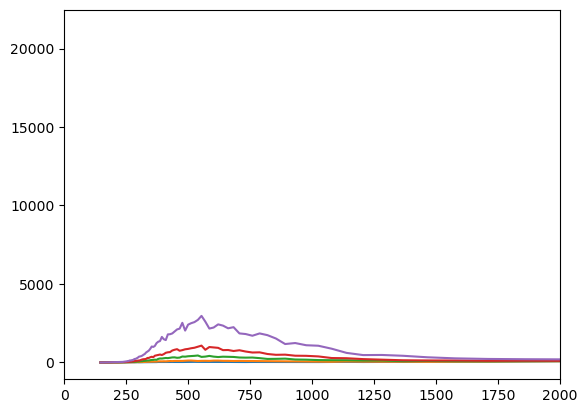

In [171]:
noise_levels = [0.05, 0.1, 0.2, 0.3, 0.5]
noise_levels = [n*2 for n in noise_levels]
subkm_noise = add_subkm_noise(sigma0, pixel_size, noise_levels, seed=None)
for sigma0_noise in subkm_noise:
    PSD_sigma0_radial_noise, _, _ = process_wind_field(sigma0_noise)
    # PSD_sigma0_radial_noise = PSD_sigma0_radial_noise[2:]

    plt.plot(1/k_values, PSD_sigma0_radial_noise)
plt.xlim(0, 2000)
plt.show()

In [102]:
sigma0_noise0

array([[0.02826042, 0.02254733, 0.02656334, ..., 0.03006586, 0.01869535,
        0.02620777],
       [0.05783247, 0.05423791, 0.09681284, ..., 0.05743116, 0.04426822,
        0.05082963],
       [0.0721441 , 0.07298102, 0.09725248, ..., 0.04282133, 0.05613268,
        0.04984866],
       ...,
       [0.06219542, 0.02958657, 0.03740759, ..., 0.10497823, 0.10532141,
        0.0997596 ],
       [0.03842263, 0.01157225, 0.02678228, ..., 0.12698814, 0.1092852 ,
        0.09134221],
       [0.02814893, 0.02143911, 0.03996673, ..., 0.11224358, 0.08952157,
        0.08467534]])

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_cmod_scale_sensitivity_aggregated(df, show_individual=False):
    """
    Plot CMOD scale sensitivity analysis aggregated across all phi_bins
    """
    # Extract all data from all rows
    all_data = []
    
    for idx, sensitivity_dict in enumerate(df['cmod_scale_sensitivity']):
        for noise_level, scale_data in sensitivity_dict.items():
            for scale, metrics in scale_data.items():
                all_data.append({
                    'phi_bin': idx,
                    'scale': int(scale.replace('m', '')),
                    'noise_level': noise_level.replace('noise_', '').replace('pct', '%'),
                    'rmse': metrics['rmse_degradation'],
                    'std_change': metrics['std_change_pct'],
                    'bias': metrics['bias']
                })
    
    plot_df = pd.DataFrame(all_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CMOD Scale Sensitivity Analysis (Aggregated across phi_bins)', fontsize=16)
    
    metrics = ['rmse', 'std_change', 'bias']
    titles = ['Wind Retrieval RMSE vs Scale', 'Wind Std Change vs Scale', 'Wind Bias vs Scale']
    ylabels = ['RMSE Degradation [m/s]', 'Std Change [%]', 'Bias [m/s]']
    
    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        ax = axes[i//2, i%2] if i < 3 else None
        if ax is None:
            continue
            
        for noise in plot_df['noise_level'].unique():
            subset = plot_df[plot_df['noise_level'] == noise]
            
            # Calculate mean and std across phi_bins for each scale
            stats = subset.groupby('scale')[metric].agg(['mean', 'std', 'count']).reset_index()
            stats['sem'] = stats['std'] / np.sqrt(stats['count'])  # Standard error
            
            # Plot individual phi_bins as light lines
            if show_individual:
                colors = plt.cm.tab10(np.linspace(0, 1, len(subset['phi_bin'].unique())))
                for j, phi_bin in enumerate(subset['phi_bin'].unique()):
                    phi_data = subset[subset['phi_bin'] == phi_bin]
                    ax.plot(phi_data['scale'], phi_data[metric], 
                           alpha=0.2, linewidth=0.5, color=colors[j])
            
            # Plot mean with error bars
            ax.errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                       marker='o', linewidth=2, capsize=3, label=f'{noise} noise')
        
        ax.set_xlabel('Spatial Scale [m]')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
    
    # Heatmap of mean RMSE
    rmse_data = plot_df[plot_df.columns[plot_df.columns != 'phi_bin']]
    pivot_rmse = rmse_data.groupby(['noise_level', 'scale'])['rmse'].mean().unstack()
    sns.heatmap(pivot_rmse, annot=True, fmt='.2f', cmap='Reds', ax=axes[1,1])
    axes[1,1].set_title('Mean RMSE Heatmap')
    axes[1,1].set_xlabel('Spatial Scale [m]')
    
    plt.tight_layout()
    return fig, plot_df

def plot_cmod_era5_comparison_aggregated(df, show_individual=False):
    """
    Plot CMOD vs ERA5 comparison aggregated across all phi_bins
    """
    # Extract all data from all rows
    all_data = []
    
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            all_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'bias': metrics['bias'],
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation'],
                'std_ratio': metrics['std_ratio']
            })
    
    plot_df = pd.DataFrame(all_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CMOD vs ERA5 Scale Comparison (Aggregated across phi_bins)', fontsize=16)
    
    metrics = ['bias', 'rmse', 'correlation', 'std_ratio']
    titles = ['CMOD-ERA5 Bias vs Scale', 'CMOD-ERA5 RMSE vs Scale', 
             'CMOD-ERA5 Correlation vs Scale', 'Standard Deviation Ratio vs Scale']
    ylabels = ['Bias [m/s]', 'RMSE [m/s]', 'Correlation', 'Std Ratio (CMOD/ERA5)']
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'd']
    
    for i, (metric, title, ylabel, color, marker) in enumerate(zip(metrics, titles, ylabels, colors, markers)):
        ax = axes[i//2, i%2]
        
        # Calculate mean and std across phi_bins for each scale
        stats = plot_df.groupby('scale')[metric].agg(['mean', 'std', 'count']).reset_index()
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        
        # Plot individual phi_bins as light lines
        if show_individual:
            for phi_bin in plot_df['phi_bin'].unique():
                phi_data = plot_df[plot_df['phi_bin'] == phi_bin]
                ax.plot(phi_data['scale'], phi_data[metric], 
                       alpha=0.2, linewidth=0.5, color=color)
        
        # Plot mean with error bars
        ax.errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                   marker=marker, linewidth=2, color=color, capsize=3)
        
        ax.set_xlabel('Spatial Scale [m]')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
        
        # Add reference lines
        if metric == 'bias':
            ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        elif metric == 'correlation':
            ax.set_ylim(0, 1)
        elif metric == 'std_ratio':
            ax.axhline(1, color='red', linestyle='--', alpha=0.5, label='Perfect match')
            ax.legend()
    
    plt.tight_layout()
    return fig, plot_df

def plot_combined_cmod_analysis_aggregated(df, show_individual=False):
    """
    Combined visualization of both analyses aggregated across phi_bins
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sensitivity analysis summary
    sens_data = []
    for idx, sensitivity_dict in enumerate(df['cmod_scale_sensitivity']):
        for scale in sensitivity_dict['noise_2pct'].keys():
            scale_num = int(scale.replace('m', ''))
            sens_data.append({
                'phi_bin': idx,
                'scale': scale_num,
                'rmse_2pct': sensitivity_dict['noise_2pct'][scale]['rmse_degradation'],
                'rmse_5pct': sensitivity_dict['noise_5pct'][scale]['rmse_degradation'],
                'rmse_10pct': sensitivity_dict['noise_10pct'][scale]['rmse_degradation']
            })
    
    sens_df = pd.DataFrame(sens_data)
    
    # Plot sensitivity with aggregation
    for noise, column in [('2%', 'rmse_2pct'), ('5%', 'rmse_5pct'), ('10%', 'rmse_10pct')]:
        stats = sens_df.groupby('scale')[column].agg(['mean', 'std', 'count']).reset_index()
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        
        if show_individual:
            colors = plt.cm.tab10(np.linspace(0, 1, len(sens_df['phi_bin'].unique())))
            for j, phi_bin in enumerate(sens_df['phi_bin'].unique()):
                phi_data = sens_df[sens_df['phi_bin'] == phi_bin]
                axes[0].plot(phi_data['scale'], phi_data[column], 
                           alpha=0.2, linewidth=0.5, color=colors[j])
        
        axes[0].errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                        marker='o', linewidth=2, capsize=3, label=f'{noise} noise')
    
    axes[0].set_xlabel('Spatial Scale [m]')
    axes[0].set_ylabel('RMSE Degradation [m/s]')
    axes[0].set_title('CMOD Noise Sensitivity (Mean ± SEM)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    
    # ERA5 comparison summary
    comp_data = []
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            comp_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation']
            })
    
    comp_df = pd.DataFrame(comp_data)
    
    ax2 = axes[1].twinx()
    
    # RMSE
    rmse_stats = comp_df.groupby('scale')['rmse'].agg(['mean', 'std', 'count']).reset_index()
    rmse_stats['sem'] = rmse_stats['std'] / np.sqrt(rmse_stats['count'])
    
    # Correlation  
    corr_stats = comp_df.groupby('scale')['correlation'].agg(['mean', 'std', 'count']).reset_index()
    corr_stats['sem'] = corr_stats['std'] / np.sqrt(corr_stats['count'])
    
    if show_individual:
        for phi_bin in comp_df['phi_bin'].unique():
            phi_data = comp_df[comp_df['phi_bin'] == phi_bin]
            axes[1].plot(phi_data['scale'], phi_data['rmse'], alpha=0.2, linewidth=0.5, color='red')
            ax2.plot(phi_data['scale'], phi_data['correlation'], alpha=0.2, linewidth=0.5, color='blue')
    
    line1 = axes[1].errorbar(rmse_stats['scale'], rmse_stats['mean'], yerr=rmse_stats['sem'],
                            marker='o', color='red', linewidth=2, capsize=3, label='RMSE')
    line2 = ax2.errorbar(corr_stats['scale'], corr_stats['mean'], yerr=corr_stats['sem'],
                        marker='s', color='blue', linewidth=2, capsize=3, label='Correlation')
    
    axes[1].set_xlabel('Spatial Scale [m]')
    axes[1].set_ylabel('RMSE [m/s]', color='red')
    ax2.set_ylabel('Correlation', color='blue')
    axes[1].set_title('CMOD vs ERA5 Performance (Mean ± SEM)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')
    ax2.set_ylim(0, 1)
    
    # Combine legends
    axes[1].legend([line1, line2], ['RMSE', 'Correlation'], loc='center right')
    
    plt.tight_layout()
    return fig

def plot_phi_bin_variability(df):
    """
    Show how much variability exists between different phi_bins
    """
    # ERA5 comparison variability
    comp_data = []
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            comp_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation'],
                'bias': metrics['bias']
            })
    
    comp_df = pd.DataFrame(comp_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics = ['rmse', 'correlation', 'bias']
    titles = ['RMSE Variability', 'Correlation Variability', 'Bias Variability']
    ylabels = ['RMSE [m/s]', 'Correlation', 'Bias [m/s]']
    
    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        # Box plot showing spread across phi_bins for each scale
        scales = sorted(comp_df['scale'].unique())
        data_for_box = [comp_df[comp_df['scale'] == scale][metric].values for scale in scales]
        
        axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
        axes[i].set_xlabel('Spatial Scale')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)
        axes[i].grid(True, alpha=0.3)
        
        if metric == 'bias':
            axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
        elif metric == 'correlation':
            axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    return fig

# Usage examples:
# fig1, data1 = plot_cmod_scale_sensitivity_aggregated(df, show_individual=True)
# fig2, data2 = plot_cmod_era5_comparison_aggregated(df, show_individual=False) 
# fig3 = plot_combined_cmod_analysis_aggregated(df, show_individual=False)
# fig4 = plot_phi_bin_variability(df)
# plt.show()

c:\Users\trouv\miniconda3\envs\msc-thesis\lib\site-packages\seaborn\utils.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
C:\Users\trouv\AppData\Local\Tem

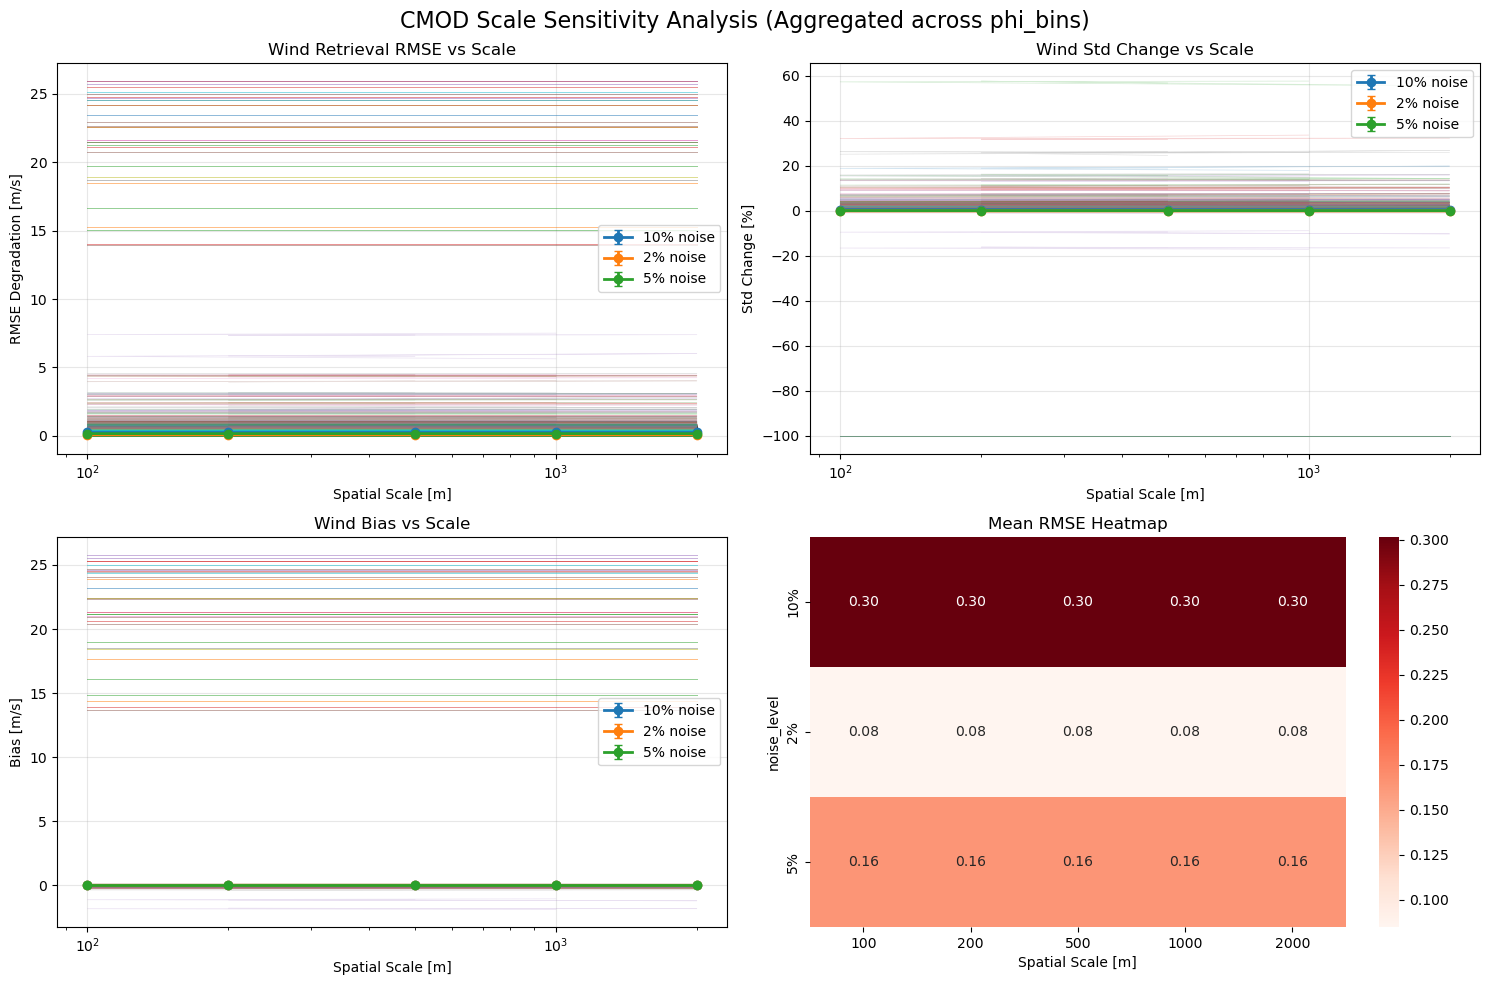

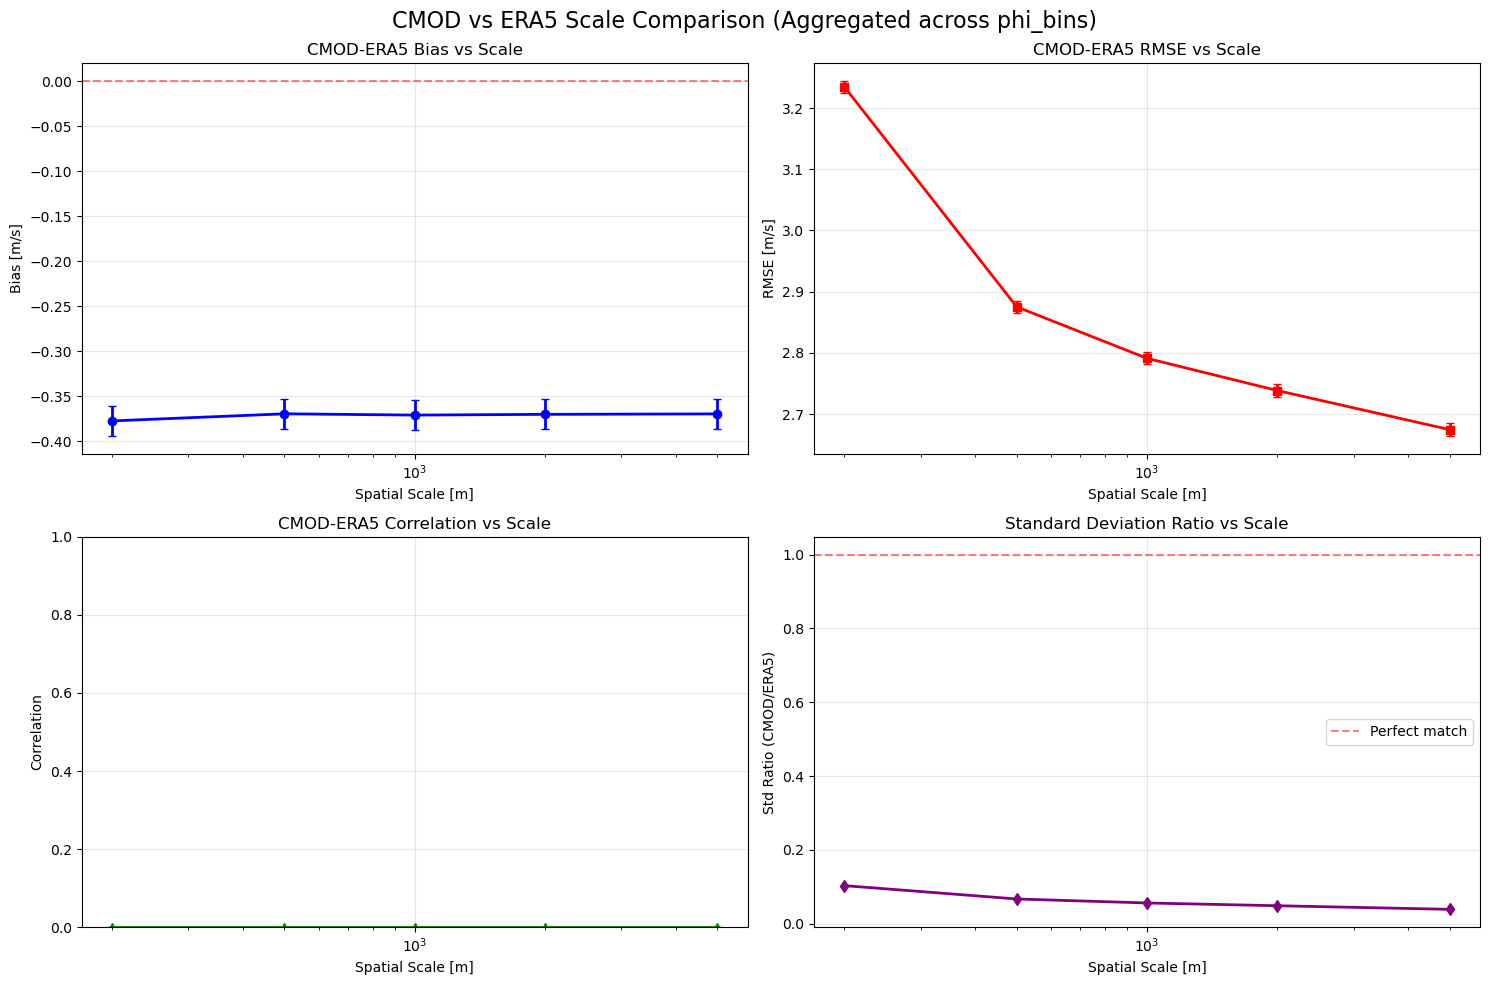

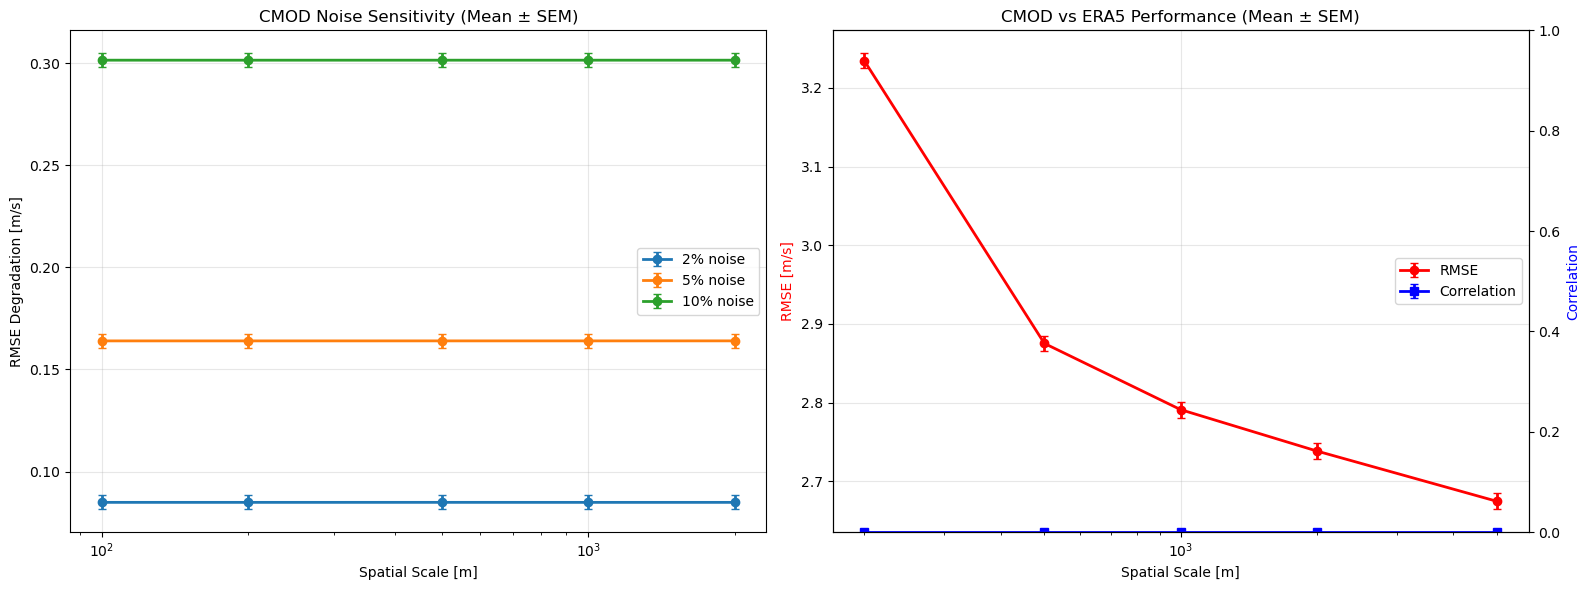

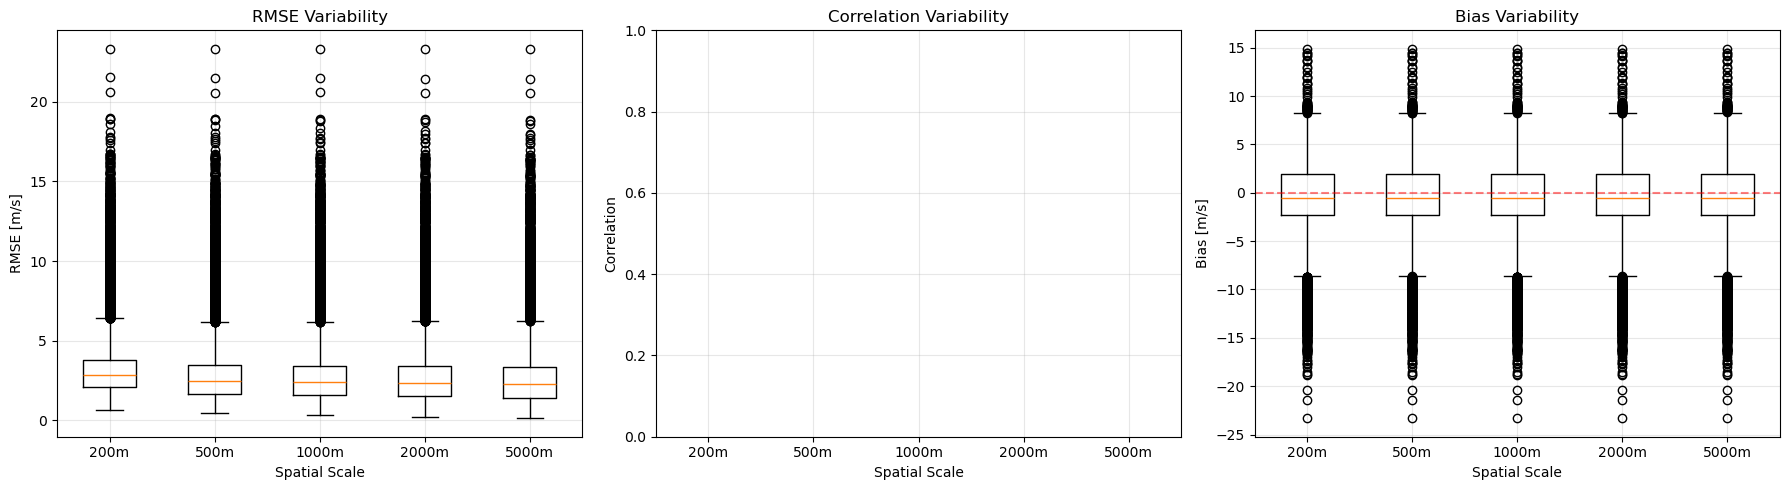

In [15]:
fig1, data1 = plot_cmod_scale_sensitivity_aggregated(df2, show_individual=True)
fig2, data2 = plot_cmod_era5_comparison_aggregated(df2, show_individual=False) 
fig3 = plot_combined_cmod_analysis_aggregated(df2, show_individual=False)
fig4 = plot_phi_bin_variability(df2)
plt.show()